The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [27]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [97]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17499636 entries, 0 to 25661583
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[us]
 18  registration   datetime64[us]
dtypes: datetime64[us](2), float64(1), int64(4), object(12)
memory usage: 2.6+ GB


In [28]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [29]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

In [30]:
# create a dataset for free users and paying users

df_train_free = df_train[df_train["level"] == "free"].copy()
df_train_paid = df_train[df_train["level"] == "paid"].copy()

In [38]:
df_train_paid.sample(10)

users_free = df_train_free["userId"]
users_paid = df_train_paid["userId"]

overlap = users_free[users_free.isin(users_paid)]
print(f"Number of overlapping users: {overlap.nunique()}")
print(f"Total number of users {df_train["userId"].nunique()}")


#Lots of users that switch from free to paid 

Number of overlapping users: 9244
Total number of users 18884


In [100]:
#Checking that code worked as expected
df_train.sort_values(by='time', ascending = True).head(10)

#!!!!!!!
# Since we only keep rows that have churn True in the last 10 days, our model could learn that a later date means more chance to churn! MERDE


,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration,will_churn_10days
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,0
15193945,200,M,Austen,free,Horton,1484921,1538352001000,Logged In,NextSong,2436,"New York-Newark-Jersey City, NY-NJ-PA",73,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",PUT,238.54975,Just Dance,Lady GaGa / Colby O'Donis,2018-10-01 00:00:01,2018-09-16 09:11:42,0
15194608,200,M,Jose,free,Goodman,1694515,1538352001000,Logged In,NextSong,2466,"Lafayette, LA",1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,231.65342,Give It Up (Album Version),The Format,2018-10-01 00:00:01,2018-09-15 04:03:02,0
1796,200,F,Vina,paid,Bailey,1697168,1538352002000,Logged In,NextSong,4593,"Hilo, HI",109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,PUT,140.35546,Baby Talk,Lush,2018-10-01 00:00:02,2018-09-08 13:48:25,0
1223,200,F,Vianney,paid,Miller,1563081,1538352002000,Logged In,NextSong,20836,"San Francisco-Oakland-Hayward, CA",9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,238.39302,MiÃÂ©ntele,Los Bunkers,2018-10-01 00:00:02,2018-09-21 03:25:18,0
15195378,200,F,Noeli,free,Harrison,1379661,1538352003000,Logged In,NextSong,133,"Dallas-Fort Worth-Arlington, TX",140,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,241.24036,All Along The Watchtower,Jimi Hendrix,2018-10-01 00:00:03,2018-07-26 17:36:54,0
15198031,200,F,Samantha,paid,Villanueva,1252007,1538352003000,Logged In,Home,3935,"Fort Collins, CO",36,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,GET,NaN,None,None,2018-10-01 00:00:03,2018-07-19 15:35:33,0
5924,200,F,Aaliyah,paid,Ramirez,1714398,1538352003000,Logged In,NextSong,22316,"Baltimore-Columbia-Towson, MD",21,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,1121.25342,Close To The Edge (I. The Solid Time Of Change...,Yes,2018-10-01 00:00:03,2018-09-19 18:23:35,0
3761,200,M,Andres,paid,Foley,1222580,1538352003000,Logged In,NextSong,6370,"Watertown, SD",71,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,277.15873,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,2018-10-01 00:00:03,2018-08-16 02:31:00,0
15195379,307,F,Noeli,free,Harrison,1379661,1538352004000,Logged In,Logout,133,"Dallas-Fort Worth-Arlington, TX",141,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,NaN,None,None,2018-10-01 00:00:04,2018-07-26 17:36:54,0


In [101]:
df_train.describe()

,status,ts,sessionId,itemInSession,length,time,registration,will_churn_10days
count,1.465755e+07,1.465755e+07,1.465755e+07,1.465755e+07,1.195098e+07,14657548,14657548,1.465755e+07
mean,2.091415e+02,1.540076e+12,7.294373e+04,1.045211e+02,2.487060e+02,2018-10-20 22:51:07.219720,2018-08-25 02:18:34.093644,1.235250e-01
min,2.000000e+02,1.538352e+12,1.000000e+00,0.000000e+00,5.220000e-01,2018-10-01 00:00:01,2017-10-14 22:05:25,0.000000e+00
25%,2.000000e+02,1.539193e+12,2.127200e+04,2.500000e+01,1.998624e+02,2018-10-10 17:35:49.750000,2018-08-10 22:00:31,0.000000e+00
50%,2.000000e+02,1.540025e+12,6.789700e+04,6.500000e+01,2.340828e+02,2018-10-20 08:43:09,2018-09-05 15:53:20,0.000000e+00
75%,2.000000e+02,1.540941e+12,1.190990e+05,1.420000e+02,2.768714e+02,2018-10-30 23:12:18,2018-09-20 15:27:40,0.000000e+00
max,4.040000e+02,1.542672e+12,2.047110e+05,1.426000e+03,3.024666e+03,2018-11-19 23:55:09,2018-11-14 23:31:27,1.000000e+00
std,3.023523e+01,1.020072e+09,5.300614e+04,1.165782e+02,9.725864e+01,NaN,NaN,3.290388e-01


In [103]:
# We add columns that could be explanatory
df_train['hour'] = df_train['time'].dt.hour
df_train['month'] = df_train['time'].dt.month

## Preliminary EDA

In [105]:
numerical_columns = ['ts', 'itemInSession', 'status', 'length','hour', 'month']
categorical_columns = ['auth', 'page', 'location', 'userAgent',
                       'method', 'song', 'artist']
target_column = ['will_churn_10days']
time_columns = ['time', 'registration']
all_columns = numerical_columns + categorical_columns + target_column + time_columns

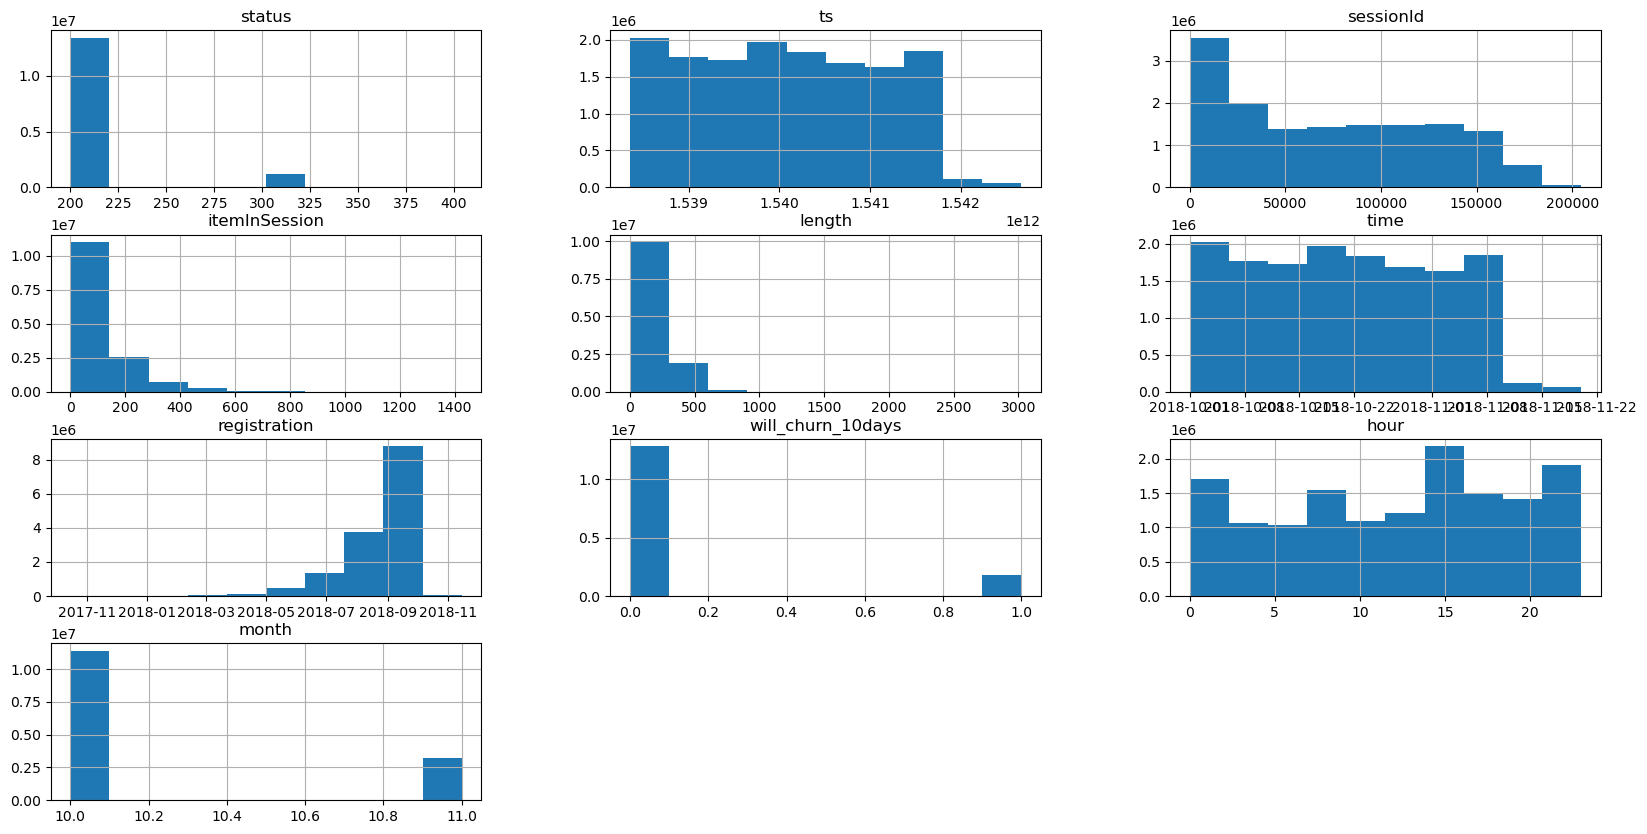

In [106]:
df_train.hist(figsize=(20, 10)); 

In [109]:
unique_counts = df_train.nunique()

print(unique_counts)

status                     3
gender                     2
firstName               4930
level                      2
lastName                1000
userId                 18884
ts                   3521777
auth                       2
page                      19
sessionId             137694
location                 875
itemInSession           1427
userAgent                 85
method                     2
length                 23169
song                  232003
artist                 36716
time                 3521777
registration           18862
will_churn_10days          2
hour                      24
month                      2
dtype: int64


In [110]:
df_train['itemInSession'].value_counts()

itemInSession
2       164595
3       163243
4       161394
5       158941
6       156489
         ...  
1374         2
1373         2
1328         2
1425         1
1426         1
Name: count, Length: 1427, dtype: int64

In [111]:
df_train['auth'].value_counts()

auth
Logged In    14653277
Cancelled        4271
Name: count, dtype: int64

In [112]:
df_train['page'].unique()

array(['NextSong', 'Downgrade', 'Help', 'Home', 'Thumbs Up', 'Add Friend',
       'Thumbs Down', 'Add to Playlist', 'Logout', 'About', 'Settings',
       'Save Settings', 'Cancel', 'Cancellation Confirmation',
       'Submit Downgrade', 'Roll Advert', 'Upgrade', 'Error',
       'Submit Upgrade'], dtype=object)

In [113]:
df_train['page'].value_counts()

page
NextSong                     11950984
Thumbs Up                      657936
Home                           543452
Add to Playlist                341986
Roll Advert                    253569
Add Friend                     219631
Logout                         172674
Thumbs Down                    139064
Downgrade                      103258
Settings                        84952
Help                            74615
Upgrade                         33542
About                           27807
Save Settings                   17069
Error                           14512
Submit Upgrade                  10215
Cancellation Confirmation        4271
Cancel                           4271
Submit Downgrade                 3740
Name: count, dtype: int64

## Feature preprocessing

In [186]:
# Sampling the dataset to try the functions:
sample_users = df_train['userId'].drop_duplicates().sample(n=1000, random_state=42)
sample_df_train = df_train[df_train['userId'].isin(sample_users)].copy()

In [187]:
# Selection of columns to simplify the dataset
columns_selection = ['userId', 'time', 'page', 'registration', 'sessionId',
              'itemInSession', 'will_churn_10days']
sample_df_train = sample_df_train[columns_selection]
sample_df_train.sample(10)

,userId,time,page,registration,sessionId,itemInSession,will_churn_10days
2057100,1554108,2018-10-26 06:07:28,NextSong,2018-09-21 01:28:00,124264,89,0
11094373,1691079,2018-11-01 06:45:33,NextSong,2018-07-28 12:37:10,130014,27,0
10340535,1907518,2018-10-22 20:40:02,NextSong,2018-09-26 08:14:01,68631,51,0
305280,1446439,2018-10-29 18:30:31,NextSong,2018-08-20 17:49:37,131674,143,0
10770060,1976556,2018-10-25 11:44:44,NextSong,2018-07-13 14:21:41,108057,113,0
659012,1920313,2018-10-16 13:07:47,NextSong,2018-09-19 09:07:58,80649,619,0
12111699,1253989,2018-10-19 13:49:07,Upgrade,2018-09-13 15:00:12,88632,23,0
6794361,1921215,2018-10-02 10:14:18,NextSong,2018-08-31 19:42:49,7831,62,0
4140699,1199654,2018-10-17 22:15:43,Home,2018-08-18 03:21:01,90598,53,0
10325033,1298544,2018-10-22 17:22:28,NextSong,2018-09-05 21:45:32,91728,57,0


### Optimized function

In [201]:
# V2

import pandas as pd
import numpy as np
from datetime import timedelta


def create_featuresV2(df_train, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (HIGHLY OPTIMIZED & CORRECTED VERSION).
    One row is created per session with features calculated on the N previous days.
    
    IMPORTANT: Features are calculated ONLY on data from BEFORE the current session
    to avoid data leakage. The sliding window is [session_start - lookback_days, session_start[,
    EXCLUDING the current session itself.
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Dataset with columns: userId, time, page, registration, sessionId, 
        itemInSession, will_churn_10days
        - registration: user's subscription date (fixed per user, used as feature)
        - time: timestamp of each log
        - sessionId: unique identifier for each session
    lookback_days : int
        Number of historical days to consider for calculating features
    batch_size : int
        Number of users to process per batch (for memory efficiency)
    
    Returns:
    --------
    pd.DataFrame
        Dataset with aggregated features, one row per session
    """
    
    print("Starting feature engineering (highly optimized & corrected)...")
    
    # Copy and optimize data types
    df = df_train.copy()
    
    print("Optimizing data types...")
    # Convert to optimal data types
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info: first log chronologically per session (vectorized)
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first',  # Session start = first log time
        'will_churn_10days': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start', 'will_churn_10days']
    
    # Pre-compute window boundaries (vectorized)
    # Sliding window: [session_start - lookback_days, session_start[
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    
    # Calculate days since registration (ensure non-negative)
    session_info['days_since_registration'] = (
        session_info['session_start'] - session_info['registration']
    ).dt.total_seconds() / 86400  # Convert to days as float
    session_info['days_since_registration'] = session_info['days_since_registration'].clip(lower=0)
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    # Get unique users and process in batches
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        # Filter data for this batch of users
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        
        # Sort batch data by userId and time for faster filtering
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        # Group by userId to process all sessions of a user together
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            # Get all logs for this user (already sorted)
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            # Pre-extract arrays for faster access
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            
            # For each session of this user (using itertuples for better performance)
            for session_row in user_sessions.itertuples(index=False):
                session_id = session_row.sessionId
                session_start = session_row.session_start
                registration_date = session_row.registration
                label = session_row.will_churn_10days
                window_start = session_row.window_start
                window_end = session_row.window_end
                days_since_registration = session_row.days_since_registration
                
                # CRITICAL FIX: Exclude current session to avoid data leakage
                exclude_current_session = user_session_ids != session_id
                
                # Vectorized filtering using numpy for speed
                # Window: [session_start - lookback_days, session_start[ EXCLUDING current session
                window_mask = (
                    (user_times >= window_start) & 
                    (user_times < window_end) & 
                    exclude_current_session
                )
                
                # Get data within the window
                window_pages = user_pages[window_mask]
                window_times = user_times[window_mask]
                window_session_ids = user_session_ids[window_mask]
                
                # Calculate inactivity: time since last action before this session
                # Previous actions: all actions before session_start, excluding current session
                previous_mask = (user_times < window_end) & exclude_current_session
                previous_times = user_times[previous_mask]
                
                if len(previous_times) > 0:
                    # Calculate hours since last action
                    last_action_time = pd.Timestamp(previous_times[-1])
                    hours_since_last_action = (session_start - last_action_time).total_seconds() / 3600
                else:
                    # First session ever: calculate hours since registration
                    hours_since_last_action = (session_start - registration_date).total_seconds() / 3600
                
                # Vectorized page counting using numpy
                if len(window_pages) > 0:
                    unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                    page_count_dict = dict(zip(unique_pages, page_counts))
                else:
                    page_count_dict = {}
                
                # Helper function for safe counting
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                
                # Calculate number of unique days with activity in the window
                if total_actions > 0:
                    days_active = len(np.unique(window_times.astype('datetime64[D]')))
                else:
                    days_active = 0
                
                # Calculate number of unique sessions in the window
                if total_actions > 0:
                    num_sessions = len(np.unique(window_session_ids))
                else:
                    num_sessions = 0
                
                # Calculate aggregated features
                features = {
                    'sessionId': session_id,
                    'userId': str(user_id),  # Convert to string for consistency
                    'session_start': session_start,
                    'registration': registration_date,
                    'will_churn_10days': label,
                    
                    # Temporal features
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Page type counts - Basic actions
                    'count_next_song': get_count('NextSong'),
                    'count_home': get_count('Home'),
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_logout': get_count('Logout'),
                    
                    # Positive engagement
                    'count_thumbs_up': get_count('Thumbs Up'),
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_playlist': get_count('Add to Playlist'),
                    'count_add_friend': get_count('Add Friend'),
                    
                    # Settings and configuration
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    
                    # Subscription actions
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    
                    # Advertisements
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global statistics
                    'total_actions': total_actions,
                    'unique_pages': len(page_count_dict),
                    
                    # Temporal statistics
                    'days_active': days_active,
                    'avg_actions_per_day': total_actions / lookback_days,
                    
                    # Sessions in the window
                    'num_sessions': num_sessions,
                    
                    # Ratios and trends - Engagement
                    'ratio_thumbs_up': get_count('Thumbs Up') / total_actions if total_actions > 0 else 0,
                    'ratio_thumbs_down': get_count('Thumbs Down') / total_actions if total_actions > 0 else 0,
                    'ratio_errors': get_count('Error') / total_actions if total_actions > 0 else 0,
                    'ratio_next_song': get_count('NextSong') / total_actions if total_actions > 0 else 0,
                    'ratio_engagement': (
                        (get_count('Add to Playlist') + get_count('Add Friend') + get_count('Thumbs Up')) / total_actions
                        if total_actions > 0 else 0
                    ),
                    
                    # Critical ratios for churn
                    'ratio_downgrade_actions': (
                        (get_count('Downgrade') + get_count('Submit Downgrade')) / total_actions
                        if total_actions > 0 else 0
                    ),
                    'ratio_help_actions': (
                        (get_count('Help') + get_count('Settings')) / total_actions
                        if total_actions > 0 else 0
                    ),
                    
                    # Binary flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    # Create final DataFrame
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    
    # Set sessionId as index
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")
    print(df_features['will_churn_10days'].value_counts())
    
    return df_features

In [202]:
# V1: old version of the function
import pandas as pd
import numpy as np
from datetime import timedelta


def create_featuresV1(df_train, lookback_days=15, batch_size=1000):
    """
    Creates aggregated features for churn prediction (HIGHLY OPTIMIZED VERSION).
    One row is created per session with features calculated on the N previous days.
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Dataset with columns: userId, time, page, registration, sessionId, 
        itemInSession, will_churn_10days
        - registration: user's subscription date (fixed per user, used as feature)
        - time: timestamp of each log
        - sessionId: unique identifier for each session
    lookback_days : int
        Number of historical days to consider for calculating features
    batch_size : int
        Number of users to process per batch (for memory efficiency)
    
    Returns:
    --------
    pd.DataFrame
        Dataset with aggregated features, one row per session
    """
    
    print("Starting feature engineering (highly optimized)...")
    
    # Copy and optimize data types
    df = df_train.copy()
    
    print("Optimizing data types...")
    # Convert to optimal data types
    df['userId'] = df['userId'].astype('category')
    df['page'] = df['page'].astype('category')
    
    print(f"Dataset size: {len(df):,} logs")
    print(f"Users: {df['userId'].nunique():,}, Sessions: {df['sessionId'].nunique():,}")
    
    # Get session info: first log chronologically per session (vectorized)
    print("Extracting session information...")
    df_sorted = df.sort_values(['sessionId', 'time'])
    session_info = df_sorted.groupby('sessionId', observed=True).agg({
        'userId': 'first',
        'registration': 'first',
        'time': 'first',  # Session start = first log time
        'will_churn_10days': 'first'
    }).reset_index()
    session_info.columns = ['sessionId', 'userId', 'registration', 'session_start', 'will_churn_10days']
    
    # Pre-compute window boundaries (vectorized)
    session_info['window_start'] = session_info['session_start'] - pd.Timedelta(days=lookback_days)
    session_info['window_end'] = session_info['session_start']
    session_info['days_since_registration'] = (
        session_info['session_start'] - session_info['registration']
    ).dt.days
    
    print(f"Processing {len(session_info):,} sessions in batches of {batch_size} users...")
    
    # Get unique users and process in batches
    unique_users = session_info['userId'].unique()
    n_batches = int(np.ceil(len(unique_users) / batch_size))
    
    all_results = []
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_users))
        batch_users = unique_users[start_idx:end_idx]
        
        # Filter data for this batch of users
        batch_df = df[df['userId'].isin(batch_users)].copy()
        batch_sessions = session_info[session_info['userId'].isin(batch_users)].copy()
        
        # Sort batch data by userId and time for faster filtering
        batch_df = batch_df.sort_values(['userId', 'time'])
        
        batch_results = []
        
        # Group by userId to process all sessions of a user together
        for user_id, user_sessions in batch_sessions.groupby('userId', observed=True):
            # Get all logs for this user (already sorted)
            user_logs = batch_df[batch_df['userId'] == user_id]
            
            if len(user_logs) == 0:
                continue
            
            # Pre-extract arrays for faster access
            user_times = user_logs['time'].values
            user_pages = user_logs['page'].values
            user_session_ids = user_logs['sessionId'].values
            
            # For each session of this user
            for _, session_row in user_sessions.iterrows():
                session_id = session_row['sessionId']
                session_start = session_row['session_start']
                registration_date = session_row['registration']
                label = session_row['will_churn_10days']
                window_start = session_row['window_start']
                window_end = session_row['window_end']
                days_since_registration = session_row['days_since_registration']
                
                # Vectorized filtering using numpy for speed
                window_mask = (user_times >= window_start) & (user_times < window_end)
                window_pages = user_pages[window_mask]
                window_session_ids = user_session_ids[window_mask]
                
                # Calculate inactivity: time since last action before this session
                previous_mask = user_times < window_end
                if previous_mask.any():
                    hours_since_last_action = (
                        session_start - pd.Timestamp(user_times[previous_mask][-1])
                    ).total_seconds() / 3600
                else:
                    hours_since_last_action = np.nan
                
                # Vectorized page counting using numpy
                unique_pages, page_counts = np.unique(window_pages, return_counts=True)
                page_count_dict = dict(zip(unique_pages, page_counts))
                
                # Helper function for safe counting
                def get_count(page_name):
                    return page_count_dict.get(page_name, 0)
                
                total_actions = len(window_pages)
                
                # Calculate aggregated features
                features = {
                    'sessionId': session_id,
                    'userId': user_id,
                    'session_start': session_start,
                    'registration': registration_date,
                    'will_churn_10days': label,
                    
                    # Temporal features
                    'hours_since_last_action': hours_since_last_action,
                    'days_since_registration': days_since_registration,
                    
                    # Page type counts - Basic actions
                    'count_next_song': get_count('NextSong'),
                    'count_home': get_count('Home'),
                    'count_help': get_count('Help'),
                    'count_about': get_count('About'),
                    'count_error': get_count('Error'),
                    'count_logout': get_count('Logout'),
                    
                    # Positive engagement
                    'count_thumbs_up': get_count('Thumbs Up'),
                    'count_thumbs_down': get_count('Thumbs Down'),
                    'count_add_playlist': get_count('Add to Playlist'),
                    'count_add_friend': get_count('Add Friend'),
                    
                    # Settings and configuration
                    'count_settings': get_count('Settings'),
                    'count_save_settings': get_count('Save Settings'),
                    
                    # Subscription actions
                    'count_downgrade': get_count('Downgrade'),
                    'count_upgrade': get_count('Upgrade'),
                    'count_submit_downgrade': get_count('Submit Downgrade'),
                    'count_submit_upgrade': get_count('Submit Upgrade'),
                    
                    # Advertisements
                    'count_roll_advert': get_count('Roll Advert'),
                    
                    # Global statistics
                    'total_actions': total_actions,
                    'unique_pages': len(unique_pages),
                    
                    # Temporal statistics
                    'days_active': len(np.unique(user_times[window_mask].astype('datetime64[D]'))) if total_actions > 0 else 0,
                    'avg_actions_per_day': total_actions / lookback_days,
                    
                    # Sessions in the window
                    'num_sessions': len(np.unique(window_session_ids)) if total_actions > 0 else 0,
                    
                    # Ratios and trends - Engagement
                    'ratio_thumbs_up': get_count('Thumbs Up') / total_actions if total_actions > 0 else 0,
                    'ratio_thumbs_down': get_count('Thumbs Down') / total_actions if total_actions > 0 else 0,
                    'ratio_errors': get_count('Error') / total_actions if total_actions > 0 else 0,
                    'ratio_engagement': (
                        (get_count('Add to Playlist') + get_count('Add Friend') + get_count('Thumbs Up')) / total_actions
                        if total_actions > 0 else 0
                    ),
                    
                    # Critical ratios for churn
                    'ratio_downgrade_actions': (
                        (get_count('Downgrade') + get_count('Submit Downgrade')) / total_actions
                        if total_actions > 0 else 0
                    ),
                    'ratio_help_actions': (
                        (get_count('Help') + get_count('Settings')) / total_actions
                        if total_actions > 0 else 0
                    ),
                    
                    # Binary flags
                    'has_downgrade_action': int(get_count('Downgrade') + get_count('Submit Downgrade') > 0),
                    'has_upgrade_action': int(get_count('Upgrade') + get_count('Submit Upgrade') > 0),
                }
                
                batch_results.append(features)
        
        all_results.extend(batch_results)
        
        if (batch_idx + 1) % 10 == 0 or batch_idx == n_batches - 1:
            print(f"  Processed batch {batch_idx + 1}/{n_batches} ({len(all_results):,} sessions so far)")
    
    # Create final DataFrame
    print("Creating final dataframe...")
    df_features = pd.DataFrame(all_results)
    
    # Set sessionId as index
    df_features = df_features.set_index('sessionId')
    
    print(f"\n✓ Final dataset: {len(df_features):,} rows, {len(df_features.columns) - 4} features")
    print(f"Label distribution:")
    print(df_features['will_churn_10days'].value_counts())
    
    return df_features

### Test of the optimized function on a small dataset

In [203]:
example1 = create_featuresV2(sample_df_train)

Starting feature engineering (highly optimized & corrected)...
Optimizing data types...
Dataset size: 746,188 logs
Users: 1,000, Sessions: 8,866
Extracting session information...
Processing 8,866 sessions in batches of 1000 users...
  Processed batch 1/1 (8,866 sessions so far)
Creating final dataframe...

✓ Final dataset: 8,866 rows, 33 features
Label distribution:
will_churn_10days
0    7967
1     899
Name: count, dtype: int64


In [205]:
example1.sample(10)

,userId,session_start,registration,will_churn_10days,hours_since_last_action,days_since_registration,count_next_song,count_home,count_help,count_about,...,num_sessions,ratio_thumbs_up,ratio_thumbs_down,ratio_errors,ratio_next_song,ratio_engagement,ratio_downgrade_actions,ratio_help_actions,has_downgrade_action,has_upgrade_action
sessionId,,,,,,,,,,,,,,,,,,,,,
98272,1577279,2018-10-18 21:01:20,2018-08-05 13:07:07,0,3.166389,74.329317,352,22,0,1,...,12,0.041394,0.002179,0.0,0.766885,0.074074,0.000000,0.013072,0,1
23067,1086305,2018-11-07 19:13:36,2018-07-09 07:56:51,0,76.075000,121.469965,241,11,1,0,...,4,0.041237,0.030928,0.0,0.828179,0.072165,0.010309,0.003436,1,0
10296,1779623,2018-10-17 02:51:35,2018-08-02 09:24:05,0,76.883889,75.727431,349,15,2,0,...,7,0.041463,0.012195,0.0,0.851220,0.080488,0.002439,0.009756,1,0
8419,1987497,2018-10-07 03:03:28,2018-05-28 11:05:15,0,17.476111,131.665428,54,5,0,0,...,2,0.075000,0.000000,0.0,0.675000,0.150000,0.000000,0.025000,0,1
97453,1190352,2018-10-22 17:10:20,2018-09-17 05:31:20,0,99.351667,35.485417,331,11,3,0,...,5,0.036176,0.007752,0.0,0.855297,0.085271,0.002584,0.012920,1,0
17890,1446251,2018-11-07 11:39:51,2018-09-04 12:54:40,0,441.269444,63.948044,0,0,0,0,...,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0
122834,1985641,2018-10-30 05:20:20,2018-08-07 11:18:11,0,114.605278,83.751493,199,9,1,0,...,2,0.046025,0.012552,0.0,0.832636,0.092050,0.016736,0.004184,1,0
31258,1452625,2018-10-02 13:49:18,2018-09-22 06:55:18,0,6.097500,10.287500,0,2,0,0,...,1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0
11435,1740976,2018-10-12 19:59:04,2018-08-31 06:28:27,1,20.734444,42.562928,59,5,0,0,...,3,0.058140,0.023256,0.0,0.686047,0.104651,0.000000,0.000000,0,0


It seems to work

### Application of the function to the whole dataset

In [223]:
df_features = create_featuresV2(df_train)

Starting feature engineering (highly optimized & corrected)...
Optimizing data types...
Dataset size: 14,657,548 logs
Users: 18,884, Sessions: 137,694
Extracting session information...
Processing 137,694 sessions in batches of 1000 users...
  Processed batch 10/17 (78,031 sessions so far)
  Processed batch 17/17 (137,694 sessions so far)
Creating final dataframe...

✓ Final dataset: 137,694 rows, 33 features
Label distribution:
will_churn_10days
0    124793
1     12901
Name: count, dtype: int64


## Rebalance the classes with a SMOTE function

In [233]:
# We apply smote only to train sets
def apply_smote(df_features):
    """
    Apply SMOTE to balance classes.
    """
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                   if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"Before SMOTE: {len(y_train)} samples")
    print(f"After SMOTE:  {len(y_train_balanced)} samples")
    print(f"Class 0: {(y_train_balanced==0).sum()}, Class 1: {(y_train_balanced==1).sum()}")
    
    return X_train_balanced, y_train_balanced, X_test, y_test

In [234]:
X_train_balanced, y_train_balanced, X_test, y_test = apply_smote(df_features)

Before SMOTE: 110155 samples
After SMOTE:  199668 samples
Class 0: 99834, Class 1: 99834


## EDA

80024     0
9809      0
140503    1
151942    1
114663    1
67639     0
111356    1
174989    1
104462    0
121289    1
182650    1
45787     0
185313    1
173623    1
12168     0
Name: will_churn_10days, dtype: int64

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 38.32it/s]


KeyboardInterrupt: 

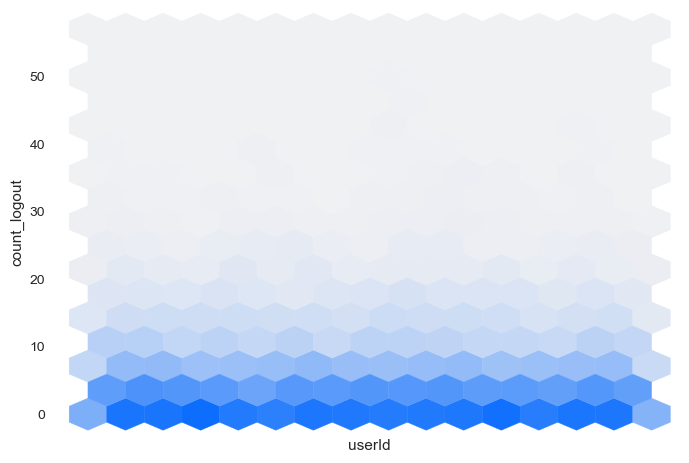

In [215]:
import ydata_profiling
X.profile_report()

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


def eda_churn_features(df_features):
    """
    Comprehensive EDA for churn prediction feature dataset.
    
    Parameters:
    -----------
    df_features : pd.DataFrame
        Output from create_churn_features() function
    """
    
    print("=" * 80)
    print("EXPLORATORY DATA ANALYSIS - CHURN PREDICTION DATASET")
    print("=" * 80)
    
    # ============================================================================
    # 1. BASIC DATASET INFO
    # ============================================================================
    print("\n1. DATASET OVERVIEW")
    print("-" * 80)
    print(f"Total sessions: {len(df_features):,}")
    print(f"Total users: {df_features['userId'].nunique():,}")
    print(f"Features: {len(df_features.columns) - 4}")  # Excluding userId, session_start, registration, label
    print(f"Date range: {df_features['session_start'].min()} to {df_features['session_start'].max()}")
    print(f"\nMemory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # ============================================================================
    # 2. TARGET VARIABLE ANALYSIS
    # ============================================================================
    print("\n\n2. TARGET VARIABLE (will_churn_10days)")
    print("-" * 80)
    churn_counts = df_features['will_churn_10days'].value_counts()
    churn_pct = df_features['will_churn_10days'].value_counts(normalize=True) * 100
    
    print(f"No Churn (0): {churn_counts.get(0, 0):,} sessions ({churn_pct.get(0, 0):.2f}%)")
    print(f"Churn (1):    {churn_counts.get(1, 0):,} sessions ({churn_pct.get(1, 0):.2f}%)")
    
    imbalance_ratio = churn_counts.max() / churn_counts.min()
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 3:
        print("⚠️  WARNING: Significant class imbalance detected!")
        print("   Consider using: SMOTE, class weights, or stratified sampling")
    
    # ============================================================================
    # 3. MISSING VALUES
    # ============================================================================
    print("\n\n3. MISSING VALUES")
    print("-" * 80)
    missing = df_features.isnull().sum()
    missing_pct = (missing / len(df_features)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing[missing > 0],
        'Percentage': missing_pct[missing > 0]
    }).sort_values('Missing Count', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df)
        print(f"\nColumns with missing values: {len(missing_df)}")
    else:
        print("✓ No missing values found!")
    
    # ============================================================================
    # 4. FEATURE STATISTICS BY CHURN STATUS
    # ============================================================================
    print("\n\n4. KEY FEATURES BY CHURN STATUS")
    print("-" * 80)
    
    # Select numeric features only
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    # Top features by difference between churners and non-churners
    churners = df_features[df_features['will_churn_10days'] == 1]
    non_churners = df_features[df_features['will_churn_10days'] == 0]
    
    feature_comparison = []
    for col in feature_cols[:20]:  # Top 20 features
        if col in churners.columns and col in non_churners.columns:
            mean_churn = churners[col].mean()
            mean_no_churn = non_churners[col].mean()
            diff_pct = ((mean_churn - mean_no_churn) / (mean_no_churn + 1e-10)) * 100
            
            feature_comparison.append({
                'Feature': col,
                'Churners (mean)': mean_churn,
                'Non-Churners (mean)': mean_no_churn,
                'Diff %': diff_pct
            })
    
    comparison_df = pd.DataFrame(feature_comparison).sort_values('Diff %', key=abs, ascending=False)
    print("\nTop 10 features with largest differences:")
    print(comparison_df.head(10).to_string(index=False))
    
    # ============================================================================
    # 5. CORRELATION WITH TARGET
    # ============================================================================
    print("\n\n5. CORRELATION WITH TARGET VARIABLE")
    print("-" * 80)
    
    correlations = df_features[feature_cols].corrwith(df_features['will_churn_10days']).abs()
    top_correlations = correlations.sort_values(ascending=False).head(15)
    
    print("Top 15 most correlated features:")
    for feat, corr in top_correlations.items():
        print(f"  {feat:40s}: {corr:.4f}")
    
    # ============================================================================
    # 6. FEATURE DISTRIBUTIONS
    # ============================================================================
    print("\n\n6. FEATURE DISTRIBUTION ANALYSIS")
    print("-" * 80)
    
    # Check for zero-variance features
    zero_var_features = [col for col in feature_cols 
                         if df_features[col].nunique() <= 1]
    if zero_var_features:
        print(f"⚠️  Zero-variance features (consider removing): {zero_var_features}")
    else:
        print("✓ No zero-variance features")
    
    # Check for highly skewed features
    skewed_features = []
    for col in feature_cols:
        if df_features[col].std() > 0:
            skewness = df_features[col].skew()
            if abs(skewness) > 2:
                skewed_features.append((col, skewness))
    
    if skewed_features:
        print(f"\n⚠️  Highly skewed features (|skew| > 2): {len(skewed_features)}")
        for feat, skew_val in sorted(skewed_features, key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"  {feat:40s}: {skew_val:.2f}")
        print("   Consider log transformation or StandardScaler")
    
    # ============================================================================
    # 7. TEMPORAL PATTERNS
    # ============================================================================
    print("\n\n7. TEMPORAL PATTERNS")
    print("-" * 80)
    
    # Account age analysis
    print(f"Days since registration:")
    print(f"  Mean: {df_features['days_since_registration'].mean():.1f} days")
    print(f"  Median: {df_features['days_since_registration'].median():.1f} days")
    print(f"  Min: {df_features['days_since_registration'].min():.1f} days")
    print(f"  Max: {df_features['days_since_registration'].max():.1f} days")
    
    # Inactivity analysis
    if 'hours_since_last_action' in df_features.columns:
        valid_hours = df_features['hours_since_last_action'].dropna()
        if len(valid_hours) > 0:
            print(f"\nHours since last action:")
            print(f"  Mean: {valid_hours.mean():.1f} hours")
            print(f"  Median: {valid_hours.median():.1f} hours")
            print(f"  75th percentile: {valid_hours.quantile(0.75):.1f} hours")
    
    # ============================================================================
    # 8. ENGAGEMENT METRICS
    # ============================================================================
    print("\n\n8. ENGAGEMENT METRICS")
    print("-" * 80)
    
    engagement_metrics = ['total_actions', 'days_active', 'num_sessions', 
                         'avg_actions_per_day', 'unique_pages']
    
    for metric in engagement_metrics:
        if metric in df_features.columns:
            print(f"\n{metric}:")
            print(f"  Overall mean: {df_features[metric].mean():.2f}")
            print(f"  Churners: {churners[metric].mean():.2f}")
            print(f"  Non-churners: {non_churners[metric].mean():.2f}")
    
    # ============================================================================
    # 9. RECOMMENDATIONS
    # ============================================================================
    print("\n\n9. MODELING RECOMMENDATIONS")
    print("-" * 80)
    
    recommendations = []
    
    # Class imbalance
    if imbalance_ratio > 3:
        recommendations.append("• Use class_weight='balanced' or SMOTE for imbalanced data")
    
    # Skewed features
    if len(skewed_features) > 5:
        recommendations.append("• Apply StandardScaler or RobustScaler for skewed features")
    
    # Missing values
    if len(missing_df) > 0:
        recommendations.append("• Handle missing values (imputation or removal)")
    
    # Correlation
    if top_correlations.max() < 0.2:
        recommendations.append("• Low correlation with target - consider feature engineering")
    
    # Zero variance
    if zero_var_features:
        recommendations.append(f"• Remove {len(zero_var_features)} zero-variance features")
    
    recommendations.append("• Use cross-validation with stratification")
    recommendations.append("• Consider ensemble methods (XGBoost, Random Forest)")
    recommendations.append("• Monitor for overfitting given feature count")
    
    if recommendations:
        for rec in recommendations:
            print(rec)
    
    print("\n" + "=" * 80)
    
    return {
        'n_sessions': len(df_features),
        'n_users': df_features['userId'].nunique(),
        'churn_rate': churn_pct.get(1, 0),
        'imbalance_ratio': imbalance_ratio,
        'top_features': top_correlations.head(10).to_dict(),
        'missing_features': missing_df.index.tolist() if len(missing_df) > 0 else [],
        'zero_var_features': zero_var_features
    }


def plot_churn_analysis(df_features):
    """
    Create visualizations for churn analysis.
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Churn Prediction - Feature Analysis', fontsize=16, fontweight='bold')
    
    # 1. Target distribution
    ax = axes[0, 0]
    df_features['will_churn_10days'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
    ax.set_title('Target Distribution')
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('Count')
    ax.set_xticklabels(['No Churn', 'Churn'], rotation=0)
    
    # 2. Total actions by churn status
    ax = axes[0, 1]
    df_features.boxplot(column='total_actions', by='will_churn_10days', ax=ax)
    ax.set_title('Total Actions by Churn Status')
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('Total Actions')
    plt.sca(ax)
    plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 3. Days since registration
    ax = axes[0, 2]
    df_features.boxplot(column='days_since_registration', by='will_churn_10days', ax=ax)
    ax.set_title('Account Age by Churn Status')
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('Days Since Registration')
    plt.sca(ax)
    plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 4. Engagement ratio by churn
    ax = axes[1, 0]
    if 'ratio_engagement' in df_features.columns:
        df_features.boxplot(column='ratio_engagement', by='will_churn_10days', ax=ax)
        ax.set_title('Engagement Ratio by Churn Status')
        ax.set_xlabel('Churn Status')
        ax.set_ylabel('Engagement Ratio')
        plt.sca(ax)
        plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 5. Error ratio by churn
    ax = axes[1, 1]
    if 'ratio_errors' in df_features.columns:
        df_features.boxplot(column='ratio_errors', by='will_churn_10days', ax=ax)
        ax.set_title('Error Ratio by Churn Status')
        ax.set_xlabel('Churn Status')
        ax.set_ylabel('Error Ratio')
        plt.sca(ax)
        plt.xticks([1, 2], ['No Churn', 'Churn'])
    
    # 6. Correlation heatmap (top features)
    ax = axes[1, 2]
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in ['userId']]
    
    # Select top correlated features with target
    correlations = df_features[feature_cols].corrwith(df_features['will_churn_10days']).abs()
    top_features = correlations.nlargest(8).index.tolist()
    
    if 'will_churn_10days' not in top_features:
        top_features.append('will_churn_10days')
    
    corr_matrix = df_features[top_features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, 
                cbar_kws={'shrink': 0.8})
    ax.set_title('Feature Correlation (Top 8)')
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Feature importance proxy (correlation bars)
    fig, ax = plt.subplots(figsize=(12, 6))
    correlations.nlargest(15).sort_values().plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Top 15 Features by Correlation with Churn', fontsize=14, fontweight='bold')
    ax.set_xlabel('Absolute Correlation')
    ax.set_ylabel('Feature')
    plt.tight_layout()
    plt.show()


# Usage example
if __name__ == "__main__":
    # Assuming df_model_ready is your output from create_churn_features()
    # results = eda_churn_features(df_model_ready)
    # plot_churn_analysis(df_model_ready)
    pass

In [228]:
eda_churn_features(df_features)

EXPLORATORY DATA ANALYSIS - CHURN PREDICTION DATASET

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total sessions: 137,694
Total users: 16,607
Features: 33
Date range: 2018-10-01 00:00:01 to 2018-11-19 21:01:46

Memory usage: 46.22 MB


2. TARGET VARIABLE (will_churn_10days)
--------------------------------------------------------------------------------
No Churn (0): 124,793 sessions (90.63%)
Churn (1):    12,901 sessions (9.37%)

Class imbalance ratio: 9.67:1
⚠️  WARNING: Significant class imbalance detected!
   Consider using: SMOTE, class weights, or stratified sampling


3. MISSING VALUES
--------------------------------------------------------------------------------
✓ No missing values found!


4. KEY FEATURES BY CHURN STATUS
--------------------------------------------------------------------------------

Top 10 features with largest differences:
            Feature  Churners (mean)  Non-Churners (mean)    Diff %
    count

{'n_sessions': 137694,
 'n_users': 16607,
 'churn_rate': np.float64(9.36932618705245),
 'imbalance_ratio': 9.673126114254709,
 'top_features': {'count_home': 0.15652713594226858,
  'total_actions': 0.15477384932640656,
  'avg_actions_per_day': 0.15477384932640645,
  'count_next_song': 0.1540972561604584,
  'count_add_playlist': 0.15326308700816899,
  'count_logout': 0.15136280027448476,
  'count_thumbs_down': 0.15005145563496425,
  'num_sessions': 0.14516862675570527,
  'count_add_friend': 0.14302583380048975,
  'count_settings': 0.13994224792726867},
 'missing_features': [],
 'zero_var_features': []}

### Remove non important features

In [216]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def find_and_remove_low_importance_features(df_features, threshold=0.01, method='random_forest'):
    """
    Find, display, and remove low importance features.
    
    Parameters:
    -----------
    df_features : pd.DataFrame
        Feature dataset with 'will_churn_10days' as target
    threshold : float
        Features with importance < threshold will be removed (default: 0.01 = 1%)
    method : str
        'random_forest' or 'correlation'
    
    Returns:
    --------
    df_cleaned : pd.DataFrame
        Dataset with low importance features removed
    removed_features : list
        List of removed feature names
    """
    
    print("=" * 70)
    print(f"REMOVING LOW IMPORTANCE FEATURES (threshold={threshold})")
    print("=" * 70)
    
    # Prepare data
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    print(f"\nOriginal features: {len(feature_cols)}")
    
    # Calculate feature importance
    if method == 'random_forest':
        print(f"Method: Random Forest")
        
        # Train quick Random Forest
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X, y)
        
        # Get importance
        importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
    elif method == 'correlation':
        print(f"Method: Correlation with target")
        
        # Calculate correlation
        importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': X.corrwith(y).abs().values
        }).sort_values('importance', ascending=False)
    
    # Find low importance features
    low_importance = importance[importance['importance'] < threshold]
    high_importance = importance[importance['importance'] >= threshold]
    
    print(f"\n--- LOW IMPORTANCE FEATURES (< {threshold}) ---")
    print(f"Found {len(low_importance)} features to remove:\n")
    print(low_importance.to_string(index=False))
    
    print(f"\n--- TOP 10 HIGH IMPORTANCE FEATURES ---")
    print(high_importance.head(10).to_string(index=False))
    
    # Remove low importance features
    features_to_keep = high_importance['feature'].tolist()
    removed_features = low_importance['feature'].tolist()
    
    # Keep metadata columns + high importance features + target
    columns_to_keep = ['userId', 'session_start', 'registration'] + features_to_keep + ['will_churn_10days']
    columns_to_keep = [col for col in columns_to_keep if col in df_features.columns]
    
    df_cleaned = df_features[columns_to_keep].copy()
    
    print(f"\n{'='*70}")
    print(f"✓ Removed {len(removed_features)} features")
    print(f"✓ Kept {len(features_to_keep)} features")
    print(f"{'='*70}")
    
    return df_cleaned, removed_features, importance


def plot_feature_importance(importance_df, top_n=20):
    """
    Plot feature importance.
    
    Parameters:
    -----------
    importance_df : pd.DataFrame
        DataFrame with 'feature' and 'importance' columns
    top_n : int
        Number of top features to display
    """
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    top_features = importance_df.head(top_n)
    
    ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance Score')
    ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def quick_comparison(df_original, df_cleaned, sample_size=10000):
    """
    Quick comparison of model performance before/after feature removal.
    
    Parameters:
    -----------
    df_original : pd.DataFrame
        Original dataset with all features
    df_cleaned : pd.DataFrame
        Dataset with low importance features removed
    sample_size : int
        Number of samples to use (for speed)
    """
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score
    
    print("\n" + "=" * 70)
    print("QUICK PERFORMANCE COMPARISON")
    print("=" * 70)
    
    # Sample data if too large
    if len(df_original) > sample_size:
        df_original = df_original.sample(n=sample_size, random_state=42)
        df_cleaned = df_cleaned.loc[df_original.index]
    
    results = {}
    
    for name, df in [('Original', df_original), ('Cleaned', df_cleaned)]:
        # Prepare data
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols 
                       if col not in ['userId', 'will_churn_10days']]
        
        X = df[feature_cols].fillna(0)
        y = df['will_churn_10days']
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Train
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        # Evaluate
        y_proba = rf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        
        results[name] = {
            'n_features': len(feature_cols),
            'roc_auc': roc_auc
        }
        
        print(f"\n{name} Dataset:")
        print(f"  Features: {len(feature_cols)}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
    
    # Summary
    print(f"\n{'='*70}")
    diff_features = results['Original']['n_features'] - results['Cleaned']['n_features']
    diff_auc = results['Cleaned']['roc_auc'] - results['Original']['roc_auc']
    
    print(f"Features removed: {diff_features}")
    print(f"ROC-AUC difference: {diff_auc:+.4f}")
    
    if abs(diff_auc) < 0.01:
        print("✓ Minimal performance loss - feature removal is safe!")
    elif diff_auc > 0:
        print("✓ Performance improved - removed noise!")
    else:
        print("⚠️  Performance decreased - consider higher threshold")
    
    print("=" * 70)


# Simple usage example
if __name__ == "__main__":
    """
    # Usage:
    
    # 1. Remove low importance features
    df_cleaned, removed, importance = find_and_remove_low_importance_features(
        df_model_ready, 
        threshold=0.01,  # Remove features with < 1% importance
        method='random_forest'  # or 'correlation'
    )
    
    # 2. Plot importance
    plot_feature_importance(importance, top_n=20)
    
    # 3. Compare performance
    quick_comparison(df_model_ready, df_cleaned)
    """
    pass

In [218]:
df_cleaned, removed, importance = find_and_remove_low_importance_features(X)

REMOVING LOW IMPORTANCE FEATURES (threshold=0.01)

Original features: 33
Method: Random Forest

--- LOW IMPORTANCE FEATURES (< 0.01) ---
Found 4 features to remove:

               feature  importance
count_submit_downgrade    0.008012
  count_submit_upgrade    0.007143
  has_downgrade_action    0.004130
    has_upgrade_action    0.002334

--- TOP 10 HIGH IMPORTANCE FEATURES ---
                feature  importance
        count_next_song    0.060985
          total_actions    0.055363
days_since_registration    0.055162
             count_home    0.048138
      count_thumbs_down    0.046579
    avg_actions_per_day    0.044352
      ratio_thumbs_down    0.043389
           num_sessions    0.041802
     count_add_playlist    0.041787
      count_roll_advert    0.040530

✓ Removed 4 features
✓ Kept 29 features


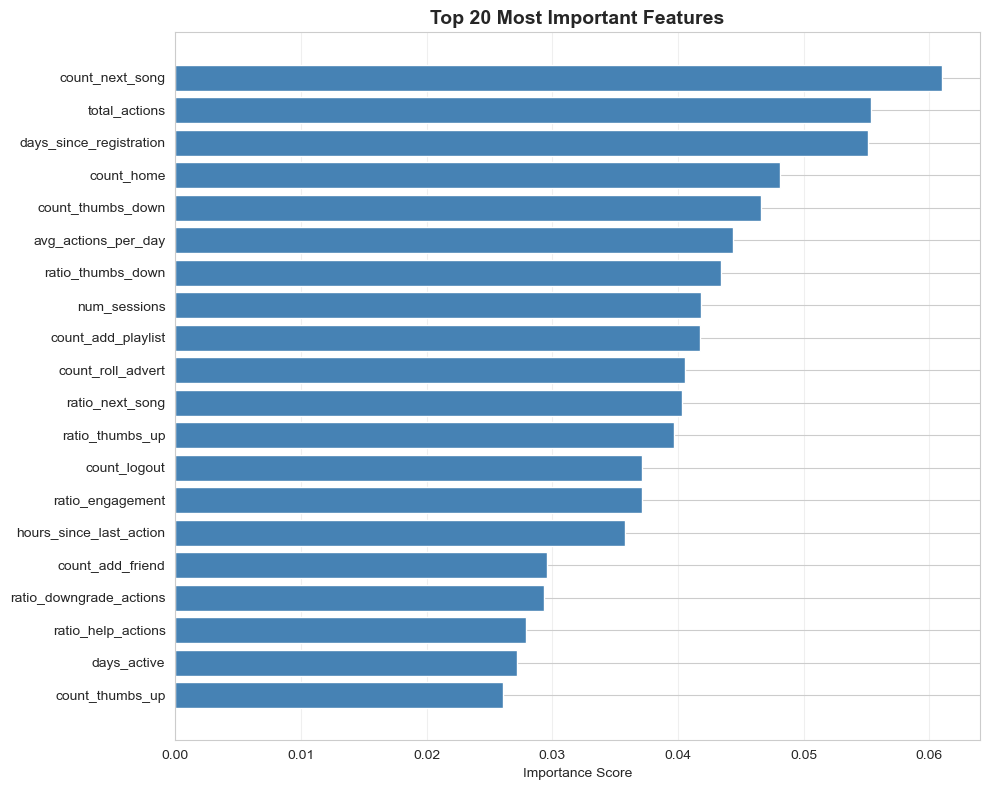

In [221]:
plot_feature_importance(importance)

## Check if linear regression is suitable

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')


def check_logistic_regression_suitability(df_features):
    """
    Comprehensive check to determine if Logistic Regression is suitable
    for your churn prediction problem.
    
    Parameters:
    -----------
    df_features : pd.DataFrame
        Feature dataset with 'will_churn_10days' as target
    """
    
    print("=" * 80)
    print("LOGISTIC REGRESSION SUITABILITY ANALYSIS")
    print("=" * 80)
    
    # Prepare data
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    print(f"\nDataset: {len(X):,} samples, {len(feature_cols)} features")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    # ========================================================================
    # 1. CHECK: Linear Separability (visual for top features)
    # ========================================================================
    print("\n" + "=" * 80)
    print("1. LINEAR SEPARABILITY CHECK")
    print("=" * 80)
    
    # Check correlation with target
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    top_features = correlations.head(5).index.tolist()
    
    print(f"\nTop 5 most correlated features with target:")
    for feat in top_features:
        corr = correlations[feat]
        print(f"  {feat:40s}: {corr:.4f}")
    
    if correlations.head(1).values[0] < 0.1:
        print("\n⚠️  WARNING: Very low correlation with target")
        print("   → Linear models might struggle")
        print("   → Consider tree-based models (XGBoost, Random Forest)")
    else:
        print("\n✓ Reasonable correlation detected")
        print("  → Linear relationships exist")
    
    # ========================================================================
    # 2. CHECK: Multicollinearity (VIF would be ideal, but computationally expensive)
    # ========================================================================
    print("\n" + "=" * 80)
    print("2. MULTICOLLINEARITY CHECK")
    print("=" * 80)
    
    # Check pairwise correlation among features
    corr_matrix = X[feature_cols[:20]].corr().abs()  # Top 20 features
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated feature pairs (>0.8):")
        for feat1, feat2, corr_val in high_corr_pairs[:5]:
            print(f"  {feat1[:30]:30s} <-> {feat2[:30]:30s}: {corr_val:.3f}")
        print("\n  → Consider removing redundant features")
        print("  → Or use regularization (L1/L2)")
    else:
        print("\n✓ No severe multicollinearity detected")
        print("  → Features are relatively independent")
    
    # ========================================================================
    # 3. CHECK: Class Balance
    # ========================================================================
    print("\n" + "=" * 80)
    print("3. CLASS BALANCE CHECK")
    print("=" * 80)
    
    class_counts = y.value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()
    minority_pct = (class_counts.min() / len(y)) * 100
    
    print(f"\nClass 0: {class_counts.get(0, 0):,} ({100 - minority_pct:.1f}%)")
    print(f"Class 1: {class_counts.get(1, 0):,} ({minority_pct:.1f}%)")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 10:
        print("\n⚠️  SEVERE CLASS IMBALANCE")
        print("  → Use class_weight='balanced' in LogisticRegression")
        print("  → Or SMOTE for oversampling minority class")
        print("  → Evaluate with ROC-AUC, not accuracy")
    elif imbalance_ratio > 3:
        print("\n⚠️  MODERATE CLASS IMBALANCE")
        print("  → Use class_weight='balanced'")
        print("  → Monitor precision/recall, not just accuracy")
    else:
        print("\n✓ Relatively balanced classes")
    
    # ========================================================================
    # 4. BASELINE MODEL: Train a simple Logistic Regression
    # ========================================================================
    print("\n" + "=" * 80)
    print("4. BASELINE LOGISTIC REGRESSION PERFORMANCE")
    print("=" * 80)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model with balanced class weights
    lr = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    )
    lr.fit(X_train, y_train)
    
    # Predictions
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"\nTest Set Performance:")
    print(f"  ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    # Interpret ROC-AUC
    print("\nROC-AUC Interpretation:")
    if roc_auc >= 0.85:
        print(f"  ✓ EXCELLENT ({roc_auc:.4f}) - Logistic Regression works very well!")
    elif roc_auc >= 0.75:
        print(f"  ✓ GOOD ({roc_auc:.4f}) - Logistic Regression is suitable")
    elif roc_auc >= 0.65:
        print(f"  ⚠️  MODERATE ({roc_auc:.4f}) - Consider ensemble methods too")
    else:
        print(f"  ❌ POOR ({roc_auc:.4f}) - Tree-based models likely better")
    
    # ========================================================================
    # 5. CROSS-VALIDATION
    # ========================================================================
    print("\n" + "=" * 80)
    print("5. CROSS-VALIDATION (5-FOLD)")
    print("=" * 80)
    
    cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='roc_auc')
    
    print(f"\nCV ROC-AUC Scores: {cv_scores}")
    print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    if cv_scores.std() > 0.05:
        print("\n⚠️  High variance in CV scores")
        print("  → Model might be unstable")
        print("  → Consider more data or regularization")
    else:
        print("\n✓ Stable performance across folds")
    
    # ========================================================================
    # 6. FEATURE IMPORTANCE
    # ========================================================================
    print("\n" + "=" * 80)
    print("6. TOP 10 MOST IMPORTANT FEATURES (by coefficient)")
    print("=" * 80)
    
    # Get feature importance (absolute coefficients)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': np.abs(lr.coef_[0])
    }).sort_values('coefficient', ascending=False)
    
    print("\n" + feature_importance.head(10).to_string(index=False))
    
    # ========================================================================
    # 7. FINAL RECOMMENDATION
    # ========================================================================
    print("\n" + "=" * 80)
    print("7. FINAL RECOMMENDATION")
    print("=" * 80)
    
    recommendations = []
    
    # Based on ROC-AUC
    if roc_auc >= 0.75:
        recommendations.append("✓ Logistic Regression is SUITABLE for your problem")
    else:
        recommendations.append("⚠️  Logistic Regression shows LIMITED performance")
        recommendations.append("   → Try XGBoost or Random Forest for comparison")
    
    # Based on correlations
    if correlations.head(1).values[0] < 0.1:
        recommendations.append("⚠️  Weak linear relationships")
        recommendations.append("   → Non-linear models might capture patterns better")
    
    # Based on multicollinearity
    if high_corr_pairs:
        recommendations.append("⚠️  High multicollinearity detected")
        recommendations.append("   → Use L1 regularization (Lasso) to select features")
        recommendations.append("   → Or use Ridge (L2) for stability")
    
    # Based on class imbalance
    if imbalance_ratio > 5:
        recommendations.append("⚠️  Severe class imbalance")
        recommendations.append("   → ALWAYS use class_weight='balanced'")
        recommendations.append("   → Evaluate with ROC-AUC and F1-score, not accuracy")
    
    # General recommendations
    recommendations.append("\nNext steps:")
    recommendations.append("1. Try Logistic Regression with L1 regularization")
    recommendations.append("2. Compare with XGBoost/Random Forest")
    recommendations.append("3. Use proper evaluation metrics (ROC-AUC, F1)")
    recommendations.append("4. Apply SMOTE if severe imbalance")
    
    print()
    for rec in recommendations:
        print(rec)
    
    print("\n" + "=" * 80)
    
    return {
        'roc_auc': roc_auc,
        'cv_scores': cv_scores,
        'top_features': feature_importance.head(10),
        'is_suitable': roc_auc >= 0.70,
        'imbalance_ratio': imbalance_ratio
    }


In [212]:

def plot_logistic_regression_diagnostics(df_features):
    """
    Create diagnostic plots for logistic regression suitability.
    """
    
    # Prepare data
    numeric_cols = df_features.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Scale and split
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train model
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    y_proba = lr.predict_proba(X_test)[:, 1]
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Logistic Regression Diagnostic Plots', fontsize=16, fontweight='bold')
    
    # 1. ROC Curve
    ax = axes[0, 0]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    
    # 2. Feature Importance
    ax = axes[0, 1]
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': np.abs(lr.coef_[0])
    }).sort_values('coefficient', ascending=False).head(15)
    
    ax.barh(range(len(feature_importance)), feature_importance['coefficient'], color='steelblue')
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['feature'])
    ax.set_xlabel('Absolute Coefficient')
    ax.set_title('Top 15 Feature Importance')
    ax.invert_yaxis()
    
    # 3. Predicted Probability Distribution
    ax = axes[1, 0]
    ax.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='No Churn', color='green')
    ax.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Churn', color='red')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')
    ax.set_title('Predicted Probability Distribution by Class')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 4. Top Feature Distributions by Class
    ax = axes[1, 1]
    top_feature = feature_importance.iloc[0]['feature']
    top_feature_idx = feature_cols.index(top_feature)
    
    ax.violinplot([X_scaled[y == 0, top_feature_idx], X_scaled[y == 1, top_feature_idx]], 
                   positions=[0, 1], showmeans=True)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_ylabel('Scaled Value')
    ax.set_title(f'Distribution of Top Feature: {top_feature}')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [213]:
check_logistic_regression_suitability(X)

LOGISTIC REGRESSION SUITABILITY ANALYSIS

Dataset: 137,694 samples, 33 features
Target distribution: {0: 124793, 1: 12901}

1. LINEAR SEPARABILITY CHECK

Top 5 most correlated features with target:
  count_home                              : 0.1565
  total_actions                           : 0.1548
  avg_actions_per_day                     : 0.1548
  count_next_song                         : 0.1541
  count_add_playlist                      : 0.1533

✓ Reasonable correlation detected
  → Linear relationships exist

2. MULTICOLLINEARITY CHECK

⚠️  Found 51 highly correlated feature pairs (>0.8):
  count_next_song                <-> count_home                    : 0.971
  count_next_song                <-> count_help                    : 0.874
  count_next_song                <-> count_logout                  : 0.919
  count_next_song                <-> count_thumbs_up               : 0.958
  count_next_song                <-> count_thumbs_down             : 0.908

  → Consider removing r

{'roc_auc': np.float64(0.6679981914525869),
 'cv_scores': array([0.56716592, 0.65918197, 0.70367595, 0.62223974, 0.67211664]),
 'top_features':                  feature  coefficient
 8        count_thumbs_up     0.507825
 23          num_sessions     0.335893
 21           days_active     0.237045
 31  has_downgrade_action     0.220947
 2        count_next_song     0.210640
 27       ratio_next_song     0.207066
 20          unique_pages     0.204647
 10    count_add_playlist     0.166871
 19         total_actions     0.156837
 22   avg_actions_per_day     0.156837,
 'is_suitable': np.False_,
 'imbalance_ratio': 9.673126114254709}

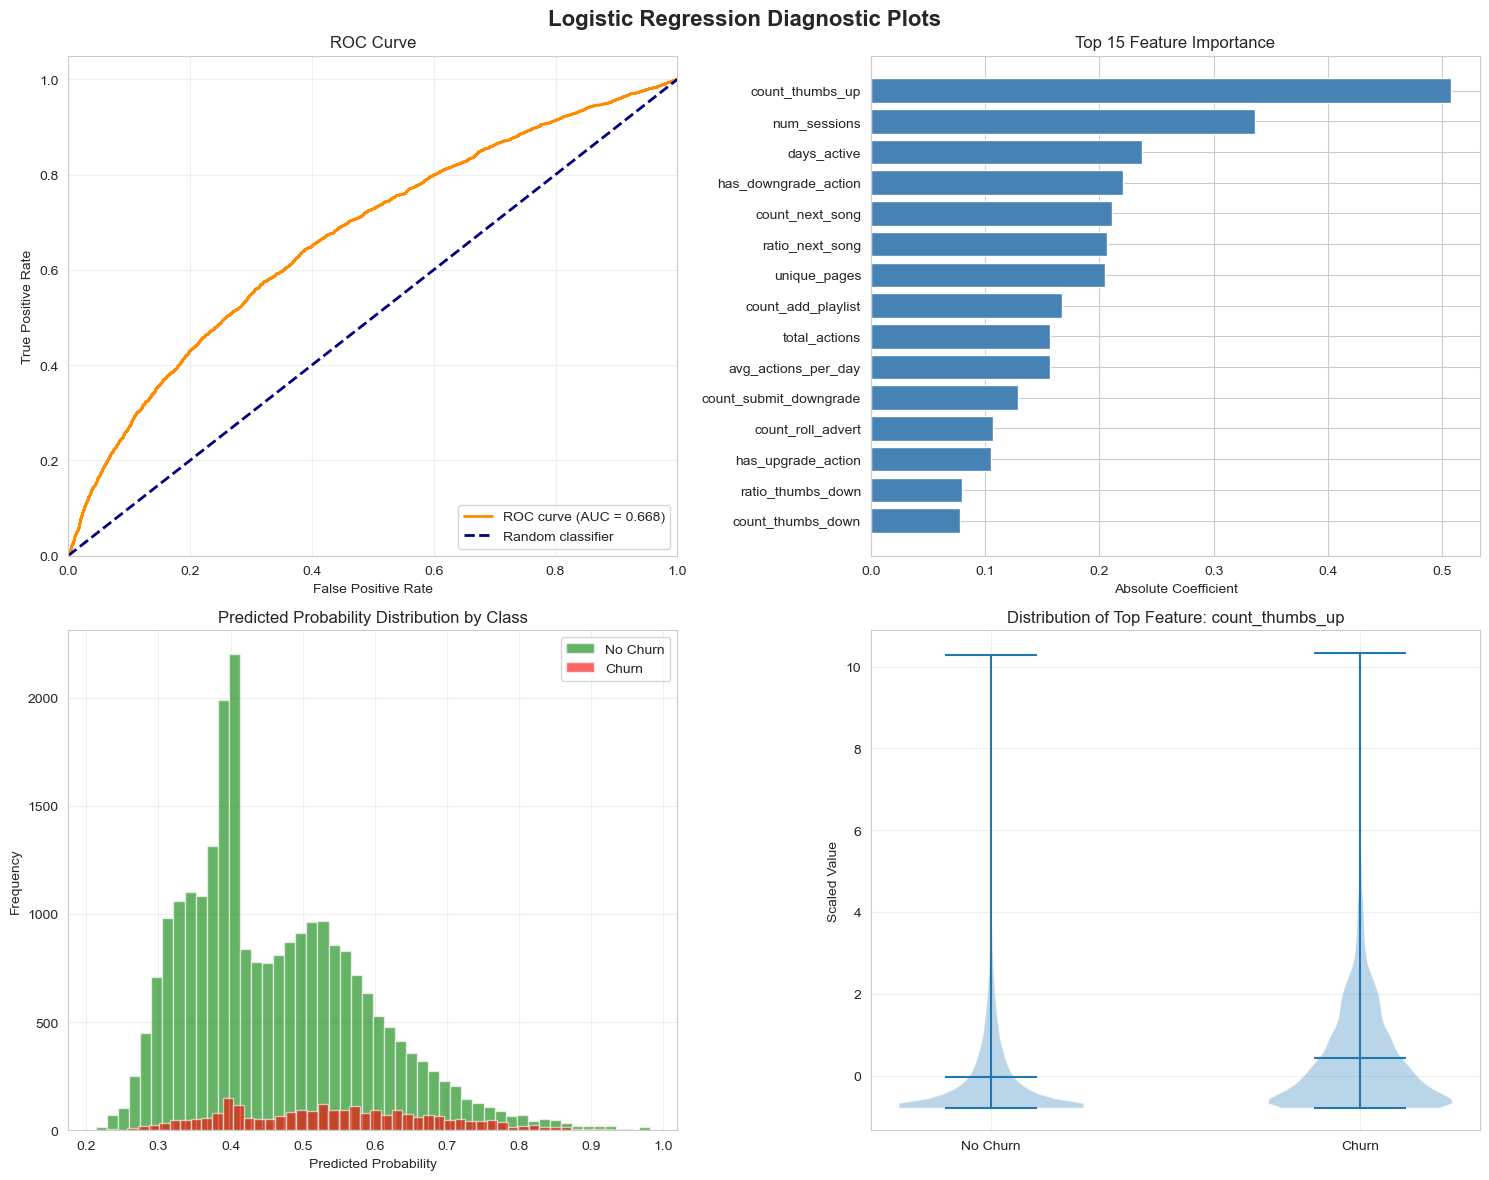

In [214]:
plot_logistic_regression_diagnostics(X)